In [1]:
import scanpy as sc
import muon as mu
import time
import pandas as pd
import numpy as np

from scipy.optimize import curve_fit, fsolve, least_squares

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

import math

import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
from scipy.stats import spearmanr

import sys
from contextlib import contextmanager
import gseapy as gp
import gc
import networkx as nx

from decimal import Decimal, getcontext
import pickle

/home/hruzko/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
correlation_df_spearman_sorted = pd.read_csv("spearman_correlation_gsea.csv")
correlation_df_spearman_sorted

,Unnamed: 0,Correlation
0,NCAPG2,0.923308
1,KLF3,0.905263
2,ORAI1,0.903759
3,RDX,0.899248
4,NDUFB10,0.899248
...,...,...
20475,RBM26-AS1,-0.789474
20476,AL355338.1,-0.816541
20477,BEND5,-0.818045
20478,PPIL3,-0.822556


In [26]:
gene_set = gp.read_gmt("go_terms.gmt")

In [27]:
gsea_supplemental_sep = gp.prerank(rnk=correlation_df_spearman_sorted, 
                         gene_sets=gene_set, 
                         outdir='prerank_output_PAN_GO_study_v0', 
                         organism='Human', 
                         permutation_num=1000,
                         verbose=True)

2025-03-04 13:55:46,945 [WARNING] Duplicated values found in preranked stats: 70.39% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-03-04 13:55:46,946 [INFO] Parsing data files for GSEA.............................
2025-03-04 13:55:46,990 [INFO] 7497 gene_sets have been filtered out when max_size=500 and min_size=15
2025-03-04 13:55:46,991 [INFO] 0571 gene_sets used for further statistical testing.....
2025-03-04 13:55:46,992 [INFO] Start to run GSEA...Might take a while..................
2025-03-04 13:56:30,103 [INFO] Start to generate gseapy reports, and produce figures...
2025-03-04 13:56:30,104 [INFO] Congratulations. GSEApy runs successfully................



In [28]:
df_res_s_GBP = gsea_supplemental_sep.res2d
df_res_s_GBP

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,GO:0022625,-0.777627,-3.960593,0.0,0.0,0.0,42/48,13.56%,RPL21;RPL23;RPL10A;RPL27;RPL15;RPL13;RPL19;RPL...
1,prerank,GO:0022627,-0.742888,-3.257461,0.0,0.0,0.0,28/32,11.11%,RPS10;RPS9;RPS5;RPS26;RPS23;RPS11;RPS15A;RPS20...
2,prerank,GO:0003735,-0.519512,-3.119687,0.0,0.0,0.0,62/111,12.68%,RPL21;RPL23;MRPS25;RPS10;RPS9;RPS5;RPL27;RPS26...
3,prerank,GO:0030488,-0.569693,-2.219111,0.0,0.00539,0.033,10/18,16.67%,TARBP1;GTPBP3;TRMT13;TRMT61A;WDR6;THUMPD2;METT...
4,prerank,GO:0002181,-0.538443,-2.103149,0.0,0.010181,0.078,13/21,13.56%,RPL22;RPL15;RPLP1;RPSA;RPL17;RPL26;RPL29;RPL35...
...,...,...,...,...,...,...,...,...,...,...
566,prerank,GO:0042742,0.123899,0.498649,0.998857,1.0,1.0,22/68,42.72%,SPN;NOD2;IGHV1-3;GNLY;IGHV4-34;MPEG1;GSDMD;IGH...
567,prerank,GO:0045165,0.160177,0.496063,0.989175,0.998651,1.0,8/19,41.85%,PRDM1;SOX13;WNT5B;WNT10B;GATA6;GATA3;GATA2;GATA1
568,prerank,GO:0009755,0.160091,0.472995,0.995873,0.99963,1.0,3/16,22.12%,PPARA;PPARG;NR1D2
569,prerank,GO:0009617,0.127194,0.422724,1.0,1.0,1.0,6/24,37.76%,TRAV13-1;TRAV5;TRAC;TRAV24;TRAV39;TRAV21


In [29]:
from goatools import obo_parser

go_obo = "go-basic.obo"
go = obo_parser.GODag(go_obo)

go-basic.obo: fmt(1.2) rel(2025-02-06) 43,597 Terms


In [30]:
def get_desc(go_id):
    try:
        return str(go[go_id].name) + f" ({go_id})"
    except KeyError:
        return "Undeff" + f" ({go_id})"

df_res_s_GBP["Term"] = df_res_s_GBP["Term"].apply(get_desc)

In [35]:
df_res_s_GBP

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,cytosolic large ribosomal subunit (GO:0022625),-0.777627,-3.960593,0.0,0.0,0.0,42/48,13.56%,RPL21;RPL23;RPL10A;RPL27;RPL15;RPL13;RPL19;RPL...
1,prerank,cytosolic small ribosomal subunit (GO:0022627),-0.742888,-3.257461,0.0,0.0,0.0,28/32,11.11%,RPS10;RPS9;RPS5;RPS26;RPS23;RPS11;RPS15A;RPS20...
2,prerank,structural constituent of ribosome (GO:0003735),-0.519512,-3.119687,0.0,0.0,0.0,62/111,12.68%,RPL21;RPL23;MRPS25;RPS10;RPS9;RPS5;RPL27;RPS26...
3,prerank,tRNA methylation (GO:0030488),-0.569693,-2.219111,0.0,0.00539,0.033,10/18,16.67%,TARBP1;GTPBP3;TRMT13;TRMT61A;WDR6;THUMPD2;METT...
4,prerank,cytoplasmic translation (GO:0002181),-0.538443,-2.103149,0.0,0.010181,0.078,13/21,13.56%,RPL22;RPL15;RPLP1;RPSA;RPL17;RPL26;RPL29;RPL35...
...,...,...,...,...,...,...,...,...,...,...
566,prerank,defense response to bacterium (GO:0042742),0.123899,0.498649,0.998857,1.0,1.0,22/68,42.72%,SPN;NOD2;IGHV1-3;GNLY;IGHV4-34;MPEG1;GSDMD;IGH...
567,prerank,cell fate commitment (GO:0045165),0.160177,0.496063,0.989175,0.998651,1.0,8/19,41.85%,PRDM1;SOX13;WNT5B;WNT10B;GATA6;GATA3;GATA2;GATA1
568,prerank,hormone-mediated signaling pathway (GO:0009755),0.160091,0.472995,0.995873,0.99963,1.0,3/16,22.12%,PPARA;PPARG;NR1D2
569,prerank,response to bacterium (GO:0009617),0.127194,0.422724,1.0,1.0,1.0,6/24,37.76%,TRAV13-1;TRAV5;TRAC;TRAV24;TRAV39;TRAV21


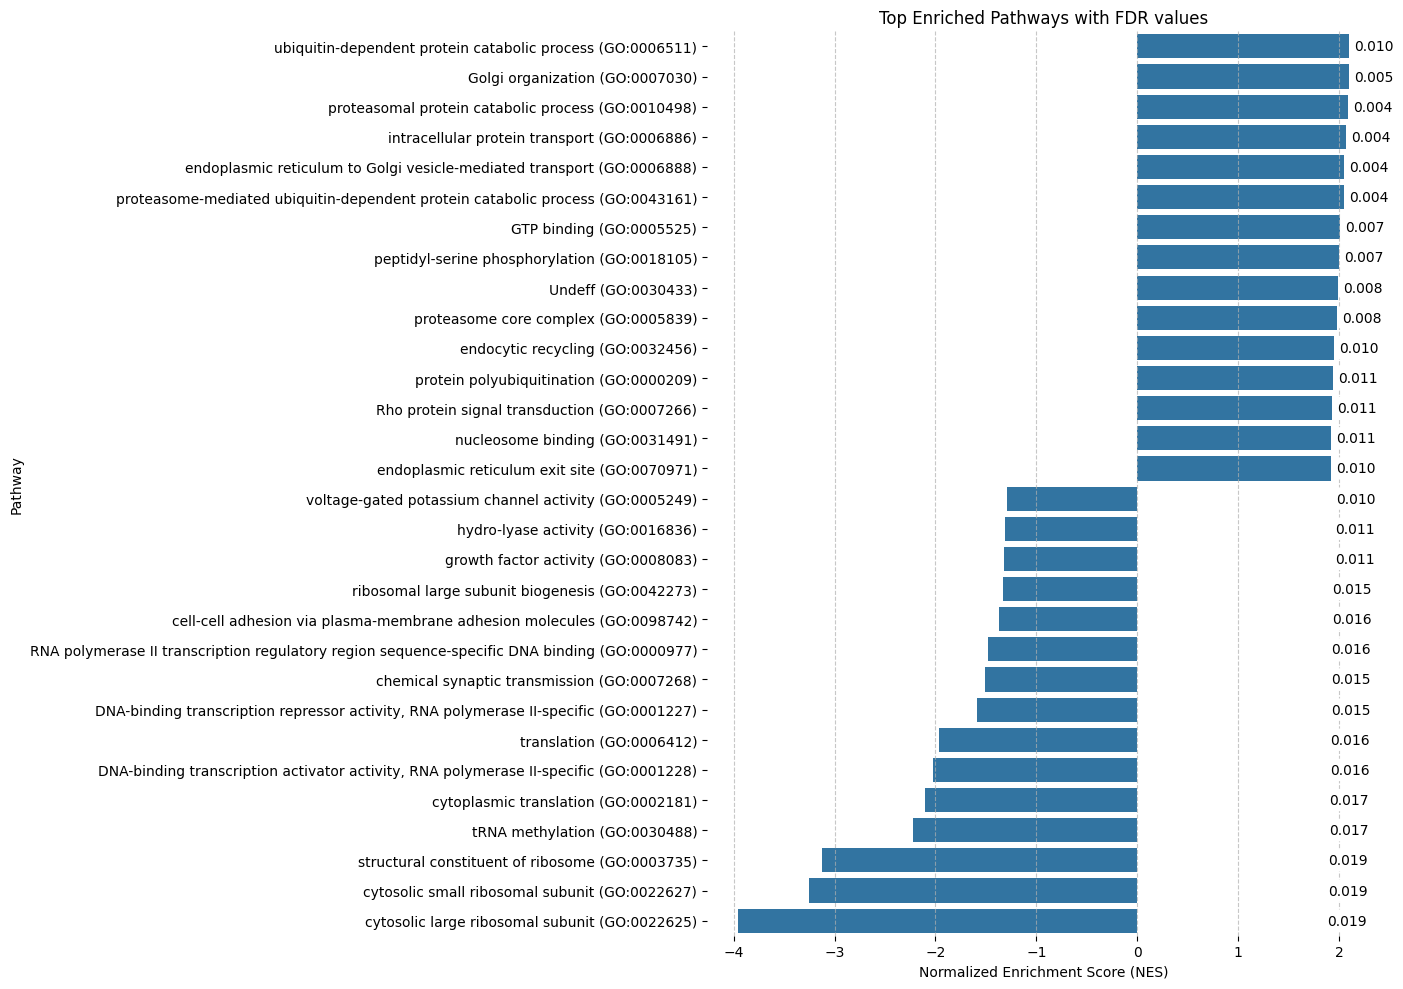

In [38]:
gsea_results = df_res_s_GBP[['Term', 'NES', 'NOM p-val', 'FDR q-val', 'Lead_genes', 'Tag %', 'Gene %']].sort_values('NES', ascending=False)

plt.figure(figsize=(14, 10))  
barplot = sns.barplot(x='NES', y='Term', data = pd.concat([gsea_results.head(15), gsea_results.tail(15)]))


for index, value in enumerate(gsea_results.head(30)['FDR q-val']):
    barplot.text(gsea_results.head(30)['NES'].iloc[index] + 0.05, index, f'{value:.3f}', color='black', ha="left", va="center", fontsize=10, bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))


plt.xlabel('Normalized Enrichment Score (NES)')
plt.ylabel('Pathway')
plt.title('Top Enriched Pathways with FDR values')


sns.despine(left=True, bottom=True)  
plt.grid(axis='x', linestyle='--', alpha=0.7)
#barplot.set(xticks=[0,0.25,0.5,0.75,1,1.25,1.5,1.75,2.0, 2.25])
plt.tight_layout()  

plt.savefig("PAN_GO_enrichement.pdf")
plt.show()